# AI vs Human Text Detection Model Training Notebook(Deep Learning Models)
This notebook covers:
1. Data Analysis & Preprocessing
2. Feature Engineering (TF-IDF, Word2Vec/GloVe/fastText) & Selection
3. Model Development & Hyperparameter Tuning (SVM, Decision Tree, AdaBoost, CNN, LSTM, RNN)
4. Performance Evaluation & Analysis (accuracy, confusion matrix, ROC curves)
5. Saving all trained models and TF-IDF vectorizer

Utilizes all available GPUs via PyTorch DataParallel.  

In [1]:
# Imports
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# Optional embeddings
# from gensim.models import KeyedVectors


In [2]:
# Device and GPU setup
print(f"PyTorch CUDA build version: {torch.version.cuda}")
print(f"cuDNN version: {torch.backends.cudnn.version()}")
print(f"Number of GPUs: {torch.cuda.device_count()}")
for i in range(torch.cuda.device_count()):
    print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")
n_gpus = torch.cuda.device_count()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PyTorch CUDA build version: 12.6
cuDNN version: 90501
Number of GPUs: 2
  GPU 0: NVIDIA RTX 5000 Ada Generation
  GPU 1: NVIDIA RTX 5000 Ada Generation


In [3]:
# Load Data
data = pd.read_excel('../data/AI_vs_huam_train_dataset.xlsx')  
data.rename(columns={'essay': 'text'}, inplace=True) 
texts = data['text']
labels = data['label']
print(data.shape)
data.head()

(3728, 2)


,text,label
0,International sports events require the most w...,0
1,Globalisation has become a significant aspect ...,0
2,There is an ever-increasing number of bullying...,0
3,"It is commonly believed, that companies should...",0
4,Despite knowing about the adverse effects of c...,0


In [4]:
# Data Analysis & Preprocessing
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')  # ensure the punkt_tab tokenizer is available
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def preprocess(text):
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha()]
    tokens = [t for t in tokens if t not in stopwords.words('english')]
    return ' '.join(tokens)

data['clean'] = data['text'].apply(preprocess)
data['clean'].head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


0    international sports events require athletes c...
1    globalisation become significant aspect world ...
2    number bullying activities numerous schools al...
3    commonly believed companies dress code policy ...
4    despite knowing adverse effects climate change...
Name: clean, dtype: object

In [5]:
# Feature Engineering: TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(data['clean'])
# Save vectorizer
os.makedirs('models', exist_ok=True)
with open('models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)


In [ ]:
# Load Pre-trained Embeddings
# word2vec = KeyedVectors.load_word2vec_format('path/to/GoogleNews-vectors-negative300.bin', binary=True)
# glove = KeyedVectors.load_word2vec_format('path/to/glove.txt')
# fasttext = KeyedVectors.load('path/to/fasttext.bin')
print("Embeddings loading stubs included")

Embeddings loading stubs included


In [7]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, labels, test_size=0.2, random_state=42
)

In [8]:
# Machine Learning Models Training & Saving
ml_models = {
    'svm': SVC(probability=True),
    'decision_tree': DecisionTreeClassifier(),
    'adaboost': AdaBoostClassifier()
}
params = {
    'svm': {'C': [0.1,1,10], 'kernel': ['linear','rbf']},
    'decision_tree': {'max_depth': [10,50,None]},
    'adaboost': {'n_estimators':[50,100], 'learning_rate':[0.5,1.0]}
}
for name, model in ml_models.items():
    print(f"Training {name}...")
    grid = GridSearchCV(model, params[name], cv=3, n_jobs=-1)
    grid.fit(X_train, y_train)
    best = grid.best_estimator_
    with open(f'models/{name}_model.pkl','wb') as f:
        pickle.dump(best, f)
    print(f"Saved {name}")

Training svm...


Saved svm
Training decision_tree...
Saved decision_tree
Training adaboost...
Saved adaboost


In [9]:
# PyTorch Dataset
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.toarray(), dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)
    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_ds = TextDataset(X_train, y_train)
test_ds = TextDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)

In [10]:
# Deep Learning Models
class CNNModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.conv1 = nn.Conv1d(1,16,3,padding=1)
        self.pool = nn.MaxPool1d(2)
        self.fc = nn.Linear((input_dim//2)*16, output_dim)
    def forward(self,x):
        x = x.unsqueeze(1)
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        return self.fc(x.view(x.size(0),-1))

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        # input_dim = 5000 features
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # x: (batch, features)
        x = x.unsqueeze(1)          # -> (batch, seq_len=1, features=5000)
        out, _ = self.lstm(x)       # now input_size matches
        return self.fc(out[:, -1, :])

class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.unsqueeze(1)          # -> (batch, 1, features)
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])


In [11]:
# Wrap models for multi-GPU & train
input_dim = train_ds.X.shape[1]
output_dim = len(set(labels))
hidden_dim = 128

raw = {'CNN':CNNModel(input_dim,output_dim),'LSTM':LSTMModel(input_dim,hidden_dim,output_dim),'RNN':RNNModel(input_dim,hidden_dim,output_dim)}
dl_models = {}
for name, model in raw.items():
    if n_gpus > 1: model = nn.DataParallel(model)
    dl_models[name] = model.to(device)

criterion = nn.CrossEntropyLoss()
for name, model in dl_models.items():
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
    print(f"Training {name}...")
    for epoch in range(5):
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            out = model(X_batch)
            loss = criterion(out, y_batch)
            loss.backward()
            optimizer.step()
    save_mod = model.module if isinstance(model, nn.DataParallel) else model
    torch.save(save_mod.state_dict(),f'models/{name}.pkl')
    print(f"Saved {name}")

Training CNN...
Saved CNN
Training LSTM...
Saved LSTM
Training RNN...
Saved RNN


svm — Accuracy: 0.971, AUC: 0.996
decision_tree — Accuracy: 0.873, AUC: 0.860
adaboost — Accuracy: 0.961, AUC: 0.991
CNN — Accuracy: 0.952, AUC: 0.990
LSTM — Accuracy: 0.971, AUC: 0.996
RNN — Accuracy: 0.971, AUC: 0.997


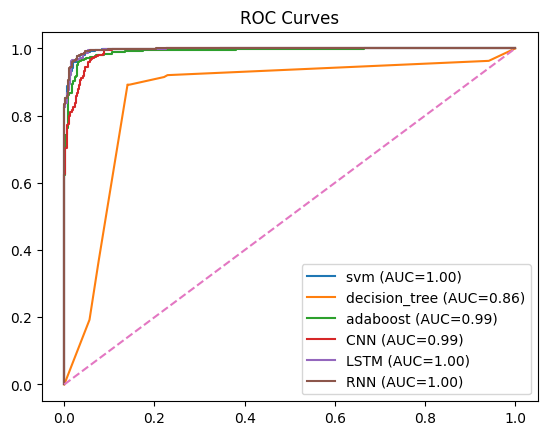

Confusion Matrix
[[376  17]
 [  5 348]]


In [12]:
# --- Performance Evaluation & Analysis ---
import numpy as np

results = {}
# First, get the true labels as a flat array:
y_true = y_test.values if hasattr(y_test, 'values') else np.array(y_test)

for name in list(ml_models.keys()) + list(dl_models.keys()):
    if name in ml_models:
        # scikit-learn model
        with open(f'models/{name}_model.pkl','rb') as f:
            m = pickle.load(f)
        preds = m.predict(X_test.toarray() if hasattr(X_test, 'toarray') else X_test)
        probs = m.predict_proba(X_test.toarray() if hasattr(X_test, 'toarray') else X_test)[:,1]
    else:
        # PyTorch model: iterate over the entire test_loader
        mdl = dl_models[name]
        mdl.eval()
        all_preds = []
        all_probs = []
        with torch.no_grad():
            for X_batch, _ in test_loader:
                X_batch = X_batch.to(device)
                out = mdl(X_batch)
                prob = torch.softmax(out, 1)[:,1].cpu().numpy()
                pred = (prob > 0.5).astype(int)
                all_probs.extend(prob.tolist())
                all_preds.extend(pred.tolist())
        preds = np.array(all_preds)
        probs = np.array(all_probs)

    # Compute metrics
    acc = accuracy_score(y_true, preds)
    fpr, tpr, _ = roc_curve(y_true, probs)
    roc_auc = auc(fpr, tpr)
    print(f"{name} — Accuracy: {acc:.3f}, AUC: {roc_auc:.3f}")
    results[name] = (fpr, tpr, roc_auc)

# Plot ROC Curves
plt.figure()
for nm,(fpr,tpr,aucv) in results.items():
    plt.plot(fpr, tpr, label=f"{nm} (AUC={aucv:.2f})")
plt.plot([0,1],[0,1],'--')
plt.legend()
plt.title('ROC Curves')
plt.show()

# Confusion Matrix for best model
cm = confusion_matrix(y_test, preds)
print('Confusion Matrix')
print(cm)